### Imports

In [211]:
import copy
from typing import List, Dict
import random
import inspyred
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## ACO

### Clases

In [212]:
class Piece:
    def __init__(self, x_dim: int, y_dim: int):
        self.x_dim = x_dim
        self.y_dim = y_dim

    def generate_random_pieces(cardinality, max_size) -> list:
        pieces = []
        for i in range(cardinality):
            pieces.append(Piece(random.randint(1, max_size),random.randint(1, max_size)))
        return pieces

In [213]:
class Choice:
    def __init__(self, piece: Piece, x_pos: int, y_pos: int):
        self.piece = piece
        self.x_pos = x_pos
        self.y_pos = y_pos

In [214]:
class Solution:
    def __init__(self, x_dim: int, y_dim: int):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.board = [[False for column in range(x_dim)] for row in range(y_dim)]
        self.used_pieces = [False for row in range(Num_Pieces)]
        self.pieces_order = [0 for row in range(Num_Pieces)]
        self.pieces_pos = [[[0,0],[0,0]] for row in range(Num_Pieces)]

    def does_Choice_fit(self, choice: Choice) -> bool:
        if choice.piece.x_dim + choice.x_pos > self.x_dim:
            return False
        if choice.piece.y_dim + choice.y_pos > self.y_dim:
            return False
        for i in range(choice.piece.x_dim):
            for j in range(choice.piece.y_dim):
                if self.board[choice.x_pos + i][choice.y_pos + j]:
                    return False
        return True
    
    def get_Choice (self, piece: Piece) -> Choice:
        for i in range(self.x_dim):  # Recorre todas las posiciones del espacio
            for j in range(self.y_dim):
                posible = Choice(piece, i, j)
                if self.does_Choice_fit(posible):
                    return Choice(piece, i, j)
        return Choice(piece, -1, -1)
                
    def place_Choice(self, choice: Choice, order: int):
        for i in range(choice.piece.x_dim):
            for j in range(choice.piece.y_dim):
                self.board[choice.x_pos + i][choice.y_pos + j] = True
        self.used_pieces[Pieces.index(choice.piece)] = True
        self.pieces_order[Pieces.index(choice.piece)] = order
        self.pieces_pos[Pieces.index(choice.piece)] = [[choice.x_pos,choice.y_pos],[choice.x_pos + choice.piece.x_dim-1,choice.y_pos + choice.piece.y_dim-1]]

    def does_use_piece(self, piece: Piece):
        return self.used_pieces[Pieces.index(piece)]
    
    def get_piece_order(self, piece: Piece):
        return self.pieces_order[Pieces.index(piece)]
    
    def piece_in_pos(self, x, y):
        i = 0
        for piece in self.pieces_pos:
            if x>= piece[0][0] and x <= piece[1][0]:
                if y>= piece[0][1] and y <= piece[1][1]:
                    return i
            i = i + 1
        return -1



    
    def huecos (self) -> list:
        board_copy = copy.deepcopy(self.board)
        array = []
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                if board_copy[i][j] == 0:
                    board_copy[i][j] = 1
                    array.append(explore_adyacent(board_copy, i, j))
        return array

    def evaluate_fitness(self) -> float: 
        espacios = self.huecos()
        value = 100
        value = value - len(espacios) * 5 #penalizar numero de huecos
        for hueco in espacios:
            value = value - (1/hueco) * 3
        return value

In [215]:
class Pheromone:
    def __init__(self):
        self.placed = 1 #considero si esta colocado o no como una feromona
        self.placeOrder = [1 for i in range(Num_Pieces)] #cada posicion indica el orden en el que se coloca la pieza

### Constantes

In [216]:
numberOfIterations = 50
Board_side = 20
Num_Pieces = 40
Alpha  = 0.9
Beta   = 0.3
Max_size_pieces = 15
Pieces = Piece.generate_random_pieces(Num_Pieces, Max_size_pieces)
bestFitnessEvolution = []
mediaFitnessEvolution = []
pheromoneHistory = []

### Utilidades

In [217]:
def clamp(value):
    if value > 0:
        return min(value, 1)
    else: 
        return max (value, 0)
    
def clampOf100(value):
    if value > 100:
        return min(value, 100)
    else: 
        return max (value, 0)
    
def explore_adyacent(temp, x, y): #hay que marcar la celda inicial antes de llamarla
    area = 0
    # Verificar si la celda adyacente está dentro de los límites del espacio
    if x + 1 < len(temp) and temp[x+1][y] == 0:
        temp[x+1][y] = 1
        area += explore_adyacent(temp, x+1, y)
    if x - 1 >= 0 and temp[x-1][y] == 0:
        temp[x-1][y] = 1
        area += explore_adyacent(temp, x-1, y)
    if y + 1 < len(temp[0]) and temp[x][y+1] == 0:
        temp[x][y+1] = 1
        area += explore_adyacent(temp, x, y+1)
    if y - 1 >= 0 and temp[x][y-1] == 0:
        temp[x][y-1] = 1
        area += explore_adyacent(temp, x, y-1)
    if temp[x][y]:
        area += 1
    return area

def printSol (sol:Solution):
    for i in range (Board_side):
        print('|', end='')  
        for j in range (Board_side):
            if sol.piece_in_pos(j, i) != -1:
                print(' ',"{:03d}".format(sol.piece_in_pos(j, i)), end='')
            else:
                print("  ·  ", end= '')
        print('|')    

    i = 0
    for piece in Pieces:
        print(i, piece.x_dim, piece.y_dim)
        i = i + 1

### Functions

In [218]:
def initialize_pheromones(): #creo un array donde cada pieza tiene una pos y un array de feromona
    Pheromones = [Pheromone() for i in range(Num_Pieces)]
    return Pheromones

In [219]:
def update_pheromones(Pheromones, Solution_list):
    New_Pheromones = Pheromones

    #Pheromones affected by evaporation
    for j in New_Pheromones:
        j.placed = clampOf100((1 - 0.8) * j.placed)
        for i in range(len(j.placeOrder)):
            j.placeOrder[i] = clampOf100((1 - 0.3) * j.placeOrder[i])

    #Pheromones affected by pheromone amount
    #Fittnes of solution multiply by 0.7
    for tempSol in Solution_list:
        tempFit = clampOf100(tempSol.evaluate_fitness() * 0.3)
        for tempPieza in range(len(Pieces)):
            if(tempSol.does_use_piece(Pieces[tempPieza])):
                New_Pheromones[tempPieza].placed = clampOf100(New_Pheromones[tempPieza].placed + tempFit)
                tempPosition = tempSol.get_piece_order(Pieces[tempPieza])
                New_Pheromones[tempPieza].placeOrder[tempPosition] = clampOf100(New_Pheromones[tempPieza].placed + tempFit)
            else:
                New_Pheromones[tempPieza].placed = clampOf100(New_Pheromones[tempPieza].placed - (tempFit * 0.6))

    return New_Pheromones

In [220]:
def get_candidates(solution: Solution) -> list:
    Candidates = []
    for candidate in Pieces:
        if not solution.does_use_piece(candidate):
            choice = solution.get_Choice(candidate)
            if choice.x_pos != -1:
                Candidates.append(choice)               
    return Candidates

In [221]:
def heuristic(choice: Choice): #good place for experimentation
    size = choice.piece.x_dim * choice.piece.y_dim
    return size / (Board_side * Board_side)

In [222]:
def calculate_probabilities(Candidates: list, Pheromones: list, order: int):
    dividend = []
    sum = 0
    for i in range(0, len(Candidates)):
        dividend.append(pow((Pheromones[i].placed * Pheromones[i].placeOrder[order]),Alpha) * pow(heuristic(Candidates[i]),Beta))
        sum += dividend[i]

    if sum == 0:
        sum = 0.000001
    for j in dividend:
        j = j/sum
    return dividend

In [223]:
def random_choice(Candidates, Probabilities):
    for i in range(len(Candidates)):
        if random.random() < Probabilities[i]: #good option for experimenting an using other choosing algos
            return Candidates[i]
    return False

In [224]:
def construct_solution(Pheromones: list) -> Solution:
    solution = Solution(Board_side, Board_side)
    Candidates = get_candidates(solution) #candidates are always valid
    order = 0
    while (len(Candidates) > 0):
        Probabilities = calculate_probabilities(Candidates, Pheromones, order)
        choice = random_choice(Candidates, Probabilities)
        if choice != False:
            solution.place_Choice(choice, order)
            Candidates = get_candidates(solution)
            order = order + 1
        #else:
        #    return solution

    return solution

### ACO definition

In [225]:
def ACO(n_ants):
    Pheromones = initialize_pheromones()
    mediaDeFitness = 0
    best_fitness = 0
    best_solution = []
    i = 0
    while (i < numberOfIterations):
        Solution_list = []
        for j in range(n_ants):
            solution = construct_solution(Pheromones)
            Solution_list.append(solution)
            fitness = solution.evaluate_fitness()
            mediaDeFitness = fitness + mediaDeFitness
            if (fitness > best_fitness):
                best_solution = solution
                best_fitness = fitness
        #guardo valores historicos para graficas
        bestFitnessEvolution.append(best_fitness)
        mediaFitnessEvolution.append(mediaDeFitness/n_ants)
        mediaDeFitness = 0
        #
        for k in range(len(Pheromones)):
            pheromoneHistory.append(Pheromones[k].placeOrder)

        Pheromones = update_pheromones(Pheromones, Solution_list)

        i = i + 1 
    return best_solution

In [226]:
sol = ACO(5)

printSol(sol)
print("Fitness:", sol.evaluate_fitness())

|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  008  008  008  008  008|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  008  008  008  008  008|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  008  008  008  008  008|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  008  008  008  008  008|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  008  008  008  008  008|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  ·    ·    ·    006  006|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  ·    ·    ·    006  006|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  005  005  ·    ·    ·    006  006|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  006  006|
|  000  000  000  000  000  000  000  000  000  003  003  003  003  004  

### Graficas

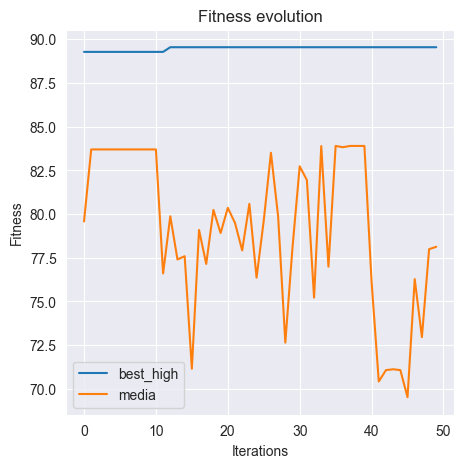

In [227]:
#Fitness evolution
sns.set_style('darkgrid')

best_fitness = np.array(bestFitnessEvolution)
media_fitness = np.array(mediaFitnessEvolution)

fig, axs = plt.subplots(figsize=(5,5))
axs.set_title('Fitness evolution')
axs.set_xlabel('Iterations')
axs.set_ylabel('Fitness')

axs.plot(best_fitness, label='best_high')
axs.plot(media_fitness, label='media')

plt.legend()

<Axes: >

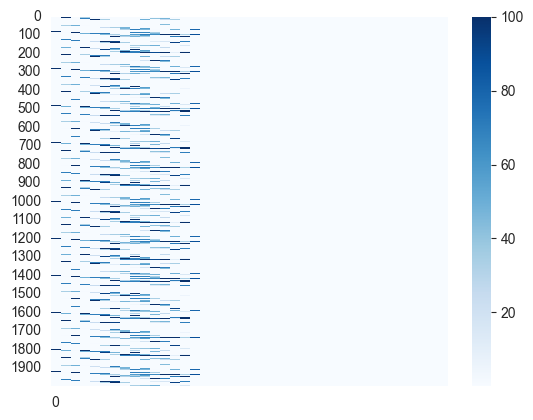

In [228]:
#Feromone evolution
pheromoneHistory = np.array(pheromoneHistory)
sns.heatmap(pheromoneHistory, cmap='Blues', xticklabels=100, yticklabels=100)

### Test

In [229]:
Alpha  = 0.0
Beta   = 0.0
bestFitnessEvolution = []
mediaFitnessEvolution = []
pheromoneHistory = []

#random test
sol = ACO(5)
printSol(sol)
print("Fitness:", sol.evaluate_fitness())

|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  016  029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  016  029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  016  029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  016  029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  016  029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  ·    029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  ·    029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  ·    029|
|  000  000  000  000  000  000  000  000  000  001  001  001  001  004  004  004  004  004  ·    029|
|  000  000  000  000  000  000  000  000  000  003  003  003  003  005  

## Genetic

### Clases

In [230]:
class Piece:
    def __init__(self, x_dim: int, y_dim: int):
        self.x_dim = x_dim
        self.y_dim = y_dim

    def generate_random_pieces(cardinality, max_size) -> list:
        pieces = []
        for i in range(cardinality):
            pieces.append(Piece(random.randint(0, max_size),random.randint(0, max_size)))
        return pieces

class RectanglePacking(inspyred.benchmarks.Benchmark): 

    def __init__(self, space):
        super(RectanglePacking, self).__init__(2)
        self.space = space
        self.bounder = inspyred.ec.Bounder([0, 0], [len(space), len(space[0])])
        self.maximize = True  # Queremos maximizar la cantidad de espacio utilizado

    
    
    def generator(self, random, args):
        pieces = []
        for i in range(Num_Pieces):
            sizex = random.randint(1, Max_size_pieces)
            sizey = random.randint(1, Max_size_pieces)
            pieza = [[1 for column in range(sizex)] for row in range(sizey)]
            pieces.append(pieza)
        return pieces


    def clamp_to_zero(number):
        if number < 0:
            return 0
        else:
            return number
    
    def imprimir_espacio(space):
        for row in space:
            print("  ".join(map(str, row)))
        print()
        

    def evaluator(self, candidates, args):
        fitness = []
        for candidate in candidates:
            total_area = 0
            space_copy = copy.deepcopy(self.space)  # Creamos una copia del espacio original para no modificarlo
            for piece in candidate:
                placed = False
                for i in range(len(space_copy) - len(piece[0]) + 1):
                    for j in range(len(space_copy[0]) - len(piece) + 1):
                        if self.is_space_available(space_copy, j, i, len(piece), len(piece[0])):
                            placed = True
                            for x in range(len(piece[0])):
                                for y in range(len(piece)):
                                    space_copy[i + x][j + y] = 1
                            total_area += len(piece) * len(piece[0])
                            break
                    if placed:
                        break
            fitness.append(total_area)
        return fitness

    def is_space_available(self, space, x, y, width, height):
        for i in range(y, y + height):
            for j in range(x, x + width):
                if space[i][j] != 0:
                    return False
        return True

### Functions

In [231]:
def colocar_pieza(space, pieza, x, y):
        temp = copy.deepcopy(space)  # Deep copy the space to avoid modifying the original
        rect_x, rect_y, rect_width, rect_height = pieza 
        if rect_x + rect_width >= len(space) or rect_y + rect_height >= len(space[0]):
            return False  # Return False if the piece goes out of bounds
        for i in range(len(pieza)):
            for j in range(len(pieza[0])):
                # Check bounds
                if space[x+i][y+j] == 1:
                    return False  # Return False if there's an overlap
                temp[x+i][y+j] = 1  # Place the piece in the temporary space
        # Copy the modified temporary space back to the original space
        for i in range(len(space)):
            for j in range(len(space[0])):
                space[i][j] = temp[i][j]
        return True  # Return True if the piece was successfully placed

### Genetic definition

In [235]:
ga = inspyred.ec.GA(rand)
def GeneticExecution():
    space = [[0 for column in range(Board_side)] for row in range(Board_side)]

    # Usar la función de envoltura personalizada en lugar de gaussian_mutation directamente
    problem = RectanglePacking(space)  # Definimos un espacio de 10x10
    rand = random.Random()
    ga.selector = inspyred.ec.selectors.tournament_selection
    ga.variator = [inspyred.ec.variators.uniform_crossover] #inspyred.ec.variators.gaussian_mutation((0.0,),(1.0,),{'_ec': ga}) no funciona
    ga.replacer = inspyred.ec.replacers.generational_replacement
    ga.terminator = inspyred.ec.terminators.generation_termination

    # Ejecución del algoritmo genético
    final_pop = ga.evolve(generator=problem.generator,
                        evaluator=problem.evaluator,
                        pop_size=10,
                        maximize=problem.maximize,
                        bounder=problem.bounder,
                        max_generations=10)

    # Mejor solución encontrada
    best = max(final_pop)
    return best

### Test

In [236]:
solGen = GeneticExecution()
print('Best Solution: {0}: {1}'.format(str(solGen.candidate), solGen.fitness))

ga.selector = inspyred.ec.selectors.uniform_selection
solGen = GeneticExecution()
print('Best Solution: {0}: {1}'.format(str(solGen.candidate), solGen.fitness))

Best Solution: [[[1, 1, 1], [1, 1, 1]], [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], [[1, 1], [1, 1]], [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], [[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]], [[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]], [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1], [1], [1], [1], [1]]]: 95
